[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


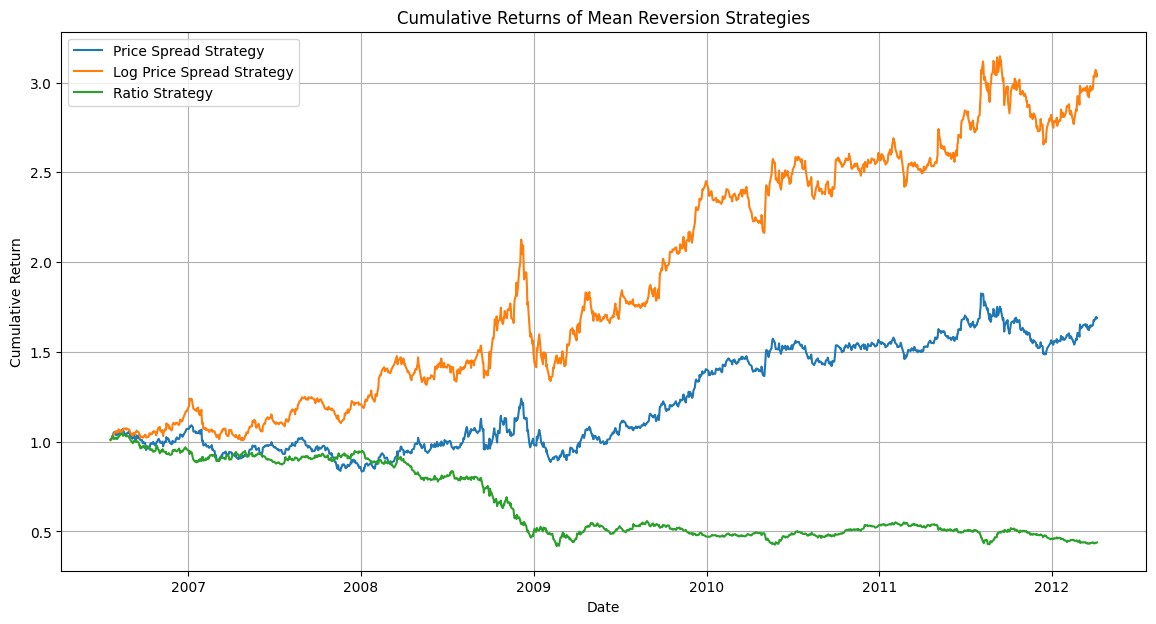

Price Spread Strategy APR: 11.07%
Price Spread Strategy Sharpe Ratio: 0.57
Log Price Spread Strategy APR: 21.84%
Log Price Spread Strategy Sharpe Ratio: 1.01
Ratio Strategy APR: -12.75%
Ratio Strategy Sharpe Ratio: -0.69


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Download data
start_date = '2006-05-24'
end_date = '2012-04-09'
gld = yf.download('GLD', start=start_date, end=end_date)['Adj Close']
uso = yf.download('USO', start=start_date, end=end_date)['Adj Close']

# Create DataFrame
data = pd.DataFrame({'GLD': gld, 'USO': uso}).dropna()

# Parameters
lookback = 20

def rolling_hedge_ratio(x, y, lookback):
    hedge_ratios = np.empty(len(x))
    hedge_ratios[:] = np.nan
    for t in range(lookback, len(x)):
        x_rolling = x[t-lookback:t]
        y_rolling = y[t-lookback:t]
        X = sm.add_constant(x_rolling)
        model = sm.OLS(y_rolling, X).fit()
        hedge_ratios[t] = model.params.iloc[1]
    return pd.Series(hedge_ratios, index=x.index)

# Price Spread
hedge_ratio_price = rolling_hedge_ratio(data['GLD'], data['USO'], lookback)
price_spread = data['USO'] - hedge_ratio_price * data['GLD']
price_spread = price_spread.dropna()

# Log Price Spread
log_gld = np.log(data['GLD'])
log_uso = np.log(data['USO'])
hedge_ratio_log = rolling_hedge_ratio(log_gld, log_uso, lookback)
log_price_spread = log_uso - hedge_ratio_log * log_gld
log_price_spread = log_price_spread.dropna()

# Ratio
ratio = data['USO'] / data['GLD']
ratio = ratio[lookback:]
data = data[lookback:]

# Moving Average and Std Dev functions
def moving_avg(series, window):
    return series.rolling(window=window).mean()

def moving_std(series, window):
    return series.rolling(window=window).std()

# Mean Reversion Strategy for Price Spread
spread = price_spread
moving_avg_spread = moving_avg(spread, lookback)
moving_std_spread = moving_std(spread, lookback)
num_units_price = -(spread - moving_avg_spread) / moving_std_spread

# Align hedge ratio with the spread
hedge_ratio_price_aligned = hedge_ratio_price[moving_avg_spread.index]
positions_price = pd.DataFrame({
    'GLD': -num_units_price * hedge_ratio_price_aligned,
    'USO': num_units_price
})
positions_price = positions_price.dropna()

# Calculate P&L and Return for Price Spread Strategy
daily_returns = data.pct_change().dropna()
pnl_price = (positions_price.shift(1) * daily_returns).sum(axis=1)
ret_price = pnl_price / positions_price.abs().shift(1).sum(axis=1)

# Cumulative Return for Price Spread Strategy
cum_ret_price = (1 + ret_price).cumprod()

# Mean Reversion Strategy for Log Price Spread
moving_avg_log = moving_avg(log_price_spread, lookback)
moving_std_log = moving_std(log_price_spread, lookback)
num_units_log = -(log_price_spread - moving_avg_log) / moving_std_log

# Align hedge ratio with the log price spread
hedge_ratio_log_aligned = hedge_ratio_log[moving_avg_log.index]
positions_log = pd.DataFrame({
    'GLD': -num_units_log * hedge_ratio_log_aligned,
    'USO': num_units_log
})
positions_log = positions_log.dropna()

# Calculate P&L and Return for Log Price Spread Strategy
pnl_log = (positions_log.shift(1) * daily_returns).sum(axis=1)
ret_log = pnl_log / positions_log.abs().shift(1).sum(axis=1)

# Cumulative Return for Log Price Spread Strategy
cum_ret_log = (1 + ret_log).cumprod()

# Ratio Strategy
moving_avg_ratio = moving_avg(ratio, lookback)
moving_std_ratio = moving_std(ratio, lookback)
num_units_ratio = -(ratio - moving_avg_ratio) / moving_std_ratio

# Create positions DataFrame
positions_ratio = pd.DataFrame({
    'GLD': -num_units_ratio,
    'USO': num_units_ratio
})
positions_ratio = positions_ratio.dropna()

# Calculate P&L and Return for Ratio Strategy
pnl_ratio = (positions_ratio.shift(1) * daily_returns).sum(axis=1)
ret_ratio = pnl_ratio / positions_ratio.abs().shift(1).sum(axis=1)

# Cumulative Return for Ratio Strategy
cum_ret_ratio = (1 + ret_ratio).cumprod()

# Plot Cumulative Returns
plt.figure(figsize=(14, 7))

plt.plot(cum_ret_price, label='Price Spread Strategy')
plt.plot(cum_ret_log, label='Log Price Spread Strategy')
plt.plot(cum_ret_ratio, label='Ratio Strategy')

plt.title('Cumulative Returns of Mean Reversion Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Performance Metrics
annual_returns_price = ret_price.mean() * 252
annual_volatility_price = ret_price.std() * np.sqrt(252)
sharpe_ratio_price = annual_returns_price / annual_volatility_price

annual_returns_log = ret_log.mean() * 252
annual_volatility_log = ret_log.std() * np.sqrt(252)
sharpe_ratio_log = annual_returns_log / annual_volatility_log

annual_returns_ratio = ret_ratio.mean() * 252
annual_volatility_ratio = ret_ratio.std() * np.sqrt(252)
sharpe_ratio_ratio = annual_returns_ratio / annual_volatility_ratio

print(f'Price Spread Strategy APR: {annual_returns_price:.2%}')
print(f'Price Spread Strategy Sharpe Ratio: {sharpe_ratio_price:.2f}')
print(f'Log Price Spread Strategy APR: {annual_returns_log:.2%}')
print(f'Log Price Spread Strategy Sharpe Ratio: {sharpe_ratio_log:.2f}')
print(f'Ratio Strategy APR: {annual_returns_ratio:.2%}')
print(f'Ratio Strategy Sharpe Ratio: {sharpe_ratio_ratio:.2f}')
